In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
from cloningCNN import ResNet
import torchvision.datasets as datasets
from torch.utils.data import sampler

#%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0,8.0)
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [3]:
model = ResNet()
model.load_state_dict(torch.load('models/ResnetQuadsVal80.pt'))


# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Per-channel means:
[0.09827528 0.06621175 0.04446544]
Per-channel stds:
[0.11947511 0.09059414 0.07569536]


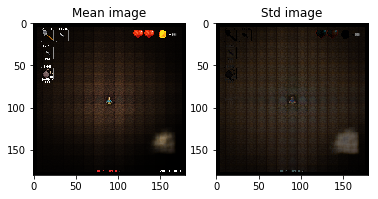

In [4]:
dset_mean = np.load("data/stats/dsetMean.npy")
dset_std = np.load("data/stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))

channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

torchchannel_means = torch.from_numpy(channel_means)
torchchannel_stds = torch.from_numpy(channel_stds)

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method
Recall in Assignment 1 you needed to select one element from each row of a matrix; if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [5]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[ 0.6941, -0.6427, -1.3639, -0.7604, -0.9298],
        [ 1.8093, -0.4232, -0.4393,  0.2705, -0.2325],
        [ 1.5369,  0.2947,  0.4074, -0.2037, -1.7335],
        [ 0.2804, -0.6265, -0.8327,  0.5917,  1.4112]])
tensor([ 1,  2,  1,  3])
tensor([-0.6427, -0.4393,  0.2947,  0.5917])


In [15]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    #X.requires_grad_()
    
    saliency = None
    split = (X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896])
    concat = torch.cat(split, dim=1)
    concat.requires_grad_()
    y_pred = model(concat)
    
    loss = y_pred.gather(1,y.view(-1,1)).squeeze() 
    loss.sum().backward()
    grad = concat.grad
    grad1 = grad[:,0:3,:,:]
    grad2 = grad[:,3:6,:,:]
    grad3 = grad[:,6:9,:,:]
    grad4 = grad[:,9:12,:,:]
    saliency1 = torch.max(torch.abs(grad1), 1)[0]
    saliency2 = torch.max(torch.abs(grad2), 1)[0]
    saliency3 = torch.max(torch.abs(grad3), 1)[0]
    saliency4 = torch.max(torch.abs(grad4), 1)[0]
    finalSaliency = torch.cat((saliency1,saliency2,saliency3,saliency4), dim=2)
    
    return finalSaliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

# INLINE QUESTION

tensor([[-1.5418, -1.6942, -1.7979,  3.8128]])
tensor([ 3])
torch.Size([1, 12, 224, 224])
torch.Size([1, 224, 896])


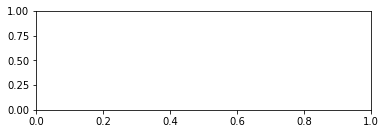

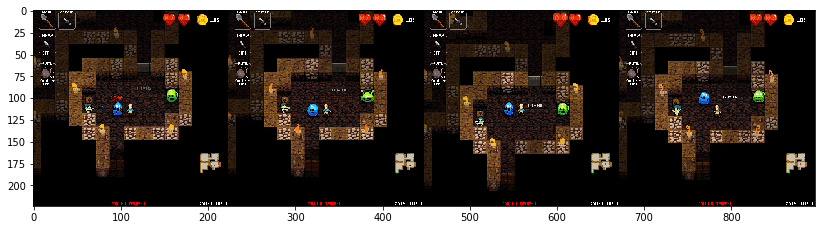

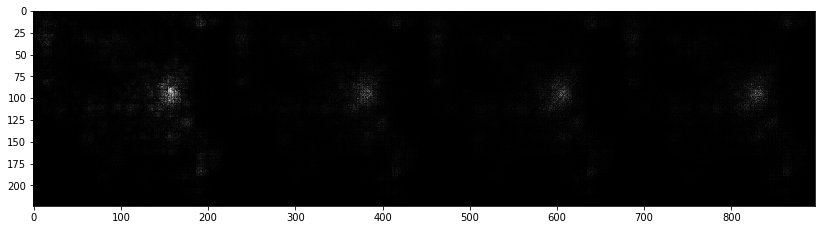

In [142]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = X#torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = y#torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    print(saliency.shape)
    N = X.shape[0]
    X = torch.transpose(torch.transpose(X, 1,3),1,2)
    for i in range(N):
        plt.subplot(2,1,1)
        #plt.subplot(2, N, i + 1)
        plt.figure(figsize=(14,10))
        plt.imshow(X[i].numpy()*channel_stds+channel_means, aspect='equal')
        plt.figure(figsize=(14,10))
        #result = Image.fromarray(saliency.numpy())

        #plt.axis('off')
        plt.subplot(2,1,2)
        plt.imshow(saliency[i].numpy(), aspect='equal')
        #plt.axis('off')
#         plt.figure(figsize=(14,10))
#         plt.subplot(3,1,3)
#         plt.imshow(X[i].numpy()*channel_stds+channel_means+ saliency[i][:,:,None], aspect='equal')
#         #plt.axis('off')
        
        image = Image.fromarray(saliency[i].numpy()*50000)
        image =image.convert('RGB')
        image.save('saliency.png')
    
    plt.show()


    
    
image_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(channel_means, channel_stds)
])


dataset = datasets.ImageFolder(root='data/classes/224scaledQuad', transform=image_transform)
num_images = len(dataset)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1,
                                           sampler=sampler.SubsetRandomSampler(range(num_images)))


wrongPrediction= True
numWrong = 0
while wrongPrediction:
    batch = next(iter(data_loader)) 
    
    X = batch[0]
    split = (X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896])
    concat = torch.cat(split, dim=1)
    y_pred = model(concat)
    
    print(y_pred)
    print(batch[1])
    if torch.argmax(y_pred) == batch[1].squeeze():
        wrongPrediction = False
    else:
        numWrong = numWrong+1
        print('got it wrong '+ str(numWrong))

show_saliency_maps(batch[0], batch[1])

tensor([[-1.5585, -1.6221, -1.6654,  0.6782]])
tensor([[ 1.6256,  1.6135,  1.6081,  ...,  1.5900,  1.5957,  1.6258],
        [ 1.6228,  1.6153,  1.6134,  ...,  1.5877,  1.5941,  1.6242],
        [ 1.6322,  1.6239,  1.6194,  ...,  1.5869,  1.5949,  1.6247],
        ...,
        [ 1.6152,  1.6146,  1.6147,  ...,  1.6260,  1.6246,  1.6239],
        [ 1.6156,  1.6143,  1.6149,  ...,  1.6254,  1.6246,  1.6240],
        [ 1.6202,  1.6185,  1.6184,  ...,  1.6256,  1.6238,  1.6230]])


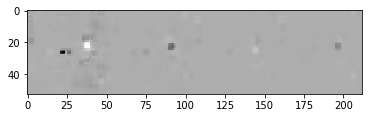

In [143]:
def occlusionHeatmap(X,y,boxSize=16,stride=4): #only takes one image
    deepX = torch.cat((X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896]),dim=1)
    grayBox = torch.ones([3,boxSize,boxSize])/2
    numHeight = int((deepX.shape[2]-boxSize)/stride)+1
    numWidth = int((deepX.shape[3]-boxSize)/stride)+1
    heatmap = torch.zeros([4,numHeight,numWidth])
    
    
    
    for depth in range(4):
        for height in range(numHeight):
            for width in range(numWidth):
                transformedX = deepX.clone()
                transformedX[:,depth*3:depth*3+3,height*stride:height*stride+boxSize,width*stride:width*stride+boxSize] = grayBox
                
#                 print(transformedX.mean())
#                 print(deepX.mean())
                #print(transformedX.shape)
                pred = model(transformedX)
#                 print(pred)
#                 print(pred[:,y])
                heatmap[depth,height,width] = pred[:,y]
    
    
    
    return torch.cat((heatmap[0],heatmap[1],heatmap[2],heatmap[3]),dim=1)

heatmap = occlusionHeatmap(batch[0],batch[1])
#print(heatmap.shape)
plt.imshow(heatmap)

#print(heatmap.numpy()/(torch.max(heatmap).numpy()))
X = batch[0] #fucking SPAGHET
baseline = model(torch.cat((X[:,:,:,:224],X[:,:,:,224:448],X[:,:,:,448:672],X[:,:,:,672:896]),dim=1))


baseline = baseline-torch.min(heatmap)
heatmap = heatmap-torch.min(heatmap)

baseline = baseline/torch.max(heatmap)
print(baseline)
print(heatmap)
heatmap = heatmap/torch.max(heatmap)

image = Image.fromarray(heatmap.numpy(), mode='F')
#image =image.convert('F')
image.save('occlusion.tiff')

In [152]:
torch.set_printoptions(threshold=5000)
#print(heatmap[:,:53])

show_saliency_maps(batch[0], batch[1])

tensor([[ 0.6790,  0.6740,  0.6717,  0.6659,  0.6648,  0.6755,  0.6857,
          0.6881,  0.6948,  0.7020,  0.6846,  0.6779,  0.6759,  0.6761,
          0.6761,  0.6785,  0.6798,  0.6805,  0.6808,  0.6796,  0.6777,
          0.6769,  0.6761,  0.6763,  0.6774,  0.6787,  0.6791,  0.6776,
          0.6768,  0.6770,  0.6758,  0.6732,  0.6720,  0.6743,  0.6794,
          0.6800,  0.6699,  0.6814,  0.6809,  0.6814,  0.6601,  0.6521,
          0.6501,  0.6723,  0.6555,  0.6405,  0.6576,  0.6476,  0.6447,
          0.6698,  0.6902,  0.6917,  0.6823],
        [ 0.6778,  0.6747,  0.6739,  0.6758,  0.6800,  0.6817,  0.6881,
          0.6876,  0.6892,  0.6855,  0.6759,  0.6746,  0.6745,  0.6744,
          0.6739,  0.6768,  0.6791,  0.6789,  0.6785,  0.6767,  0.6749,
          0.6746,  0.6734,  0.6734,  0.6739,  0.6754,  0.6768,  0.6745,
          0.6741,  0.6742,  0.6739,  0.6711,  0.6711,  0.6739,  0.6790,
          0.6800,  0.6703,  0.6819,  0.6809,  0.6799,  0.6520,  0.6430,
          0.6438, 

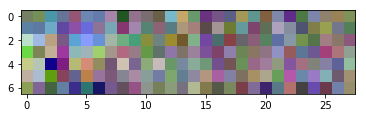

In [115]:
firstLayer = model.resnet.conv1.weight.data


individualFilter = firstLayer[18]
spreadOut = torch.cat((individualFilter[0:3],individualFilter[3:6],individualFilter[6:9],individualFilter[9:12]),dim=2)
spreadOut = torch.transpose(torch.transpose(spreadOut, 0,2),0,1)
#print(spreadOut.numpy()*channel_stds+channel_means)

maximum = torch.max(spreadOut)
minimum = torch.min(spreadOut)
finalImage = (spreadOut - minimum) / (maximum - minimum)
plt.imshow(finalImage)

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [8]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1
    
    for i in range(100):
        y_pred = model(X_fooling)
        if torch.argmax(y_pred) == target_y:
            print("Fooled in " + str(i) + " iterations!")
            break
        
        loss = y_pred[:,target_y]
        loss.backward()
        
        with torch.no_grad():
            grad = X_fooling.grad/(X_fooling.grad.norm())
            X_fooling += grad * learning_rate
            
            X_fooling.grad.zero_()
    
    return X_fooling

Run the following cell to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

In [9]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Fooled in 10 iterations!


After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

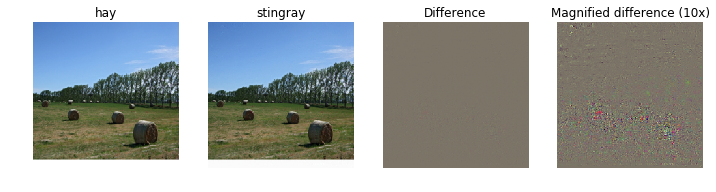

In [10]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [11]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [12]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        y_pred = model(img)
        loss = y_pred[:,target_y] - l2_reg * img.norm()**2
        loss.backward()
        
        with torch.no_grad():
            grad = img.grad#/(img.grad.norm())
            img += grad * learning_rate
            
            img.grad.zero_()
        
        
        
        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(8, 8)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

Once you have completed the implementation in the cell above, run the following cell to generate an image of a Tarantula:

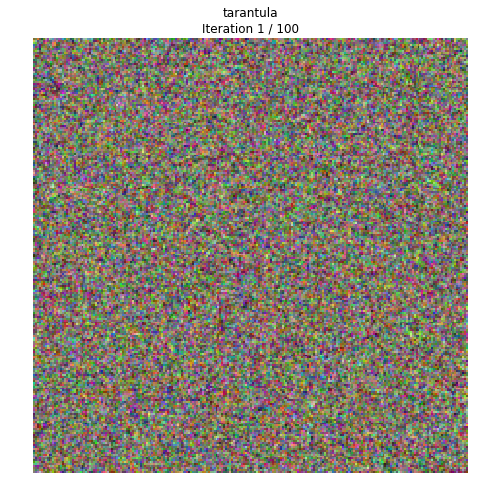

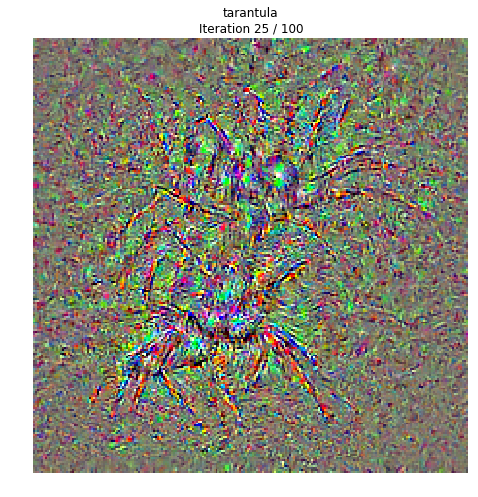

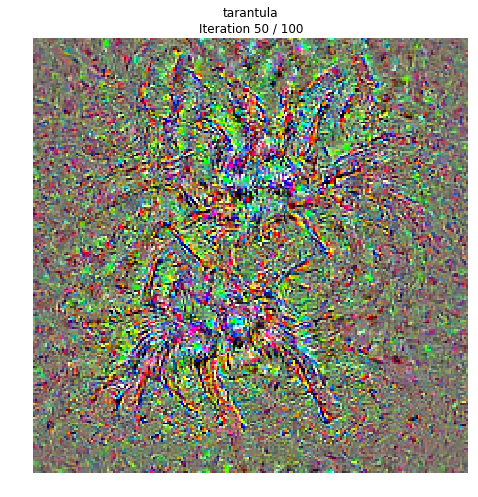

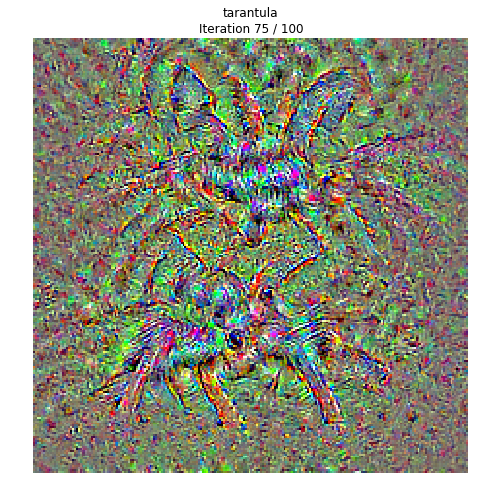

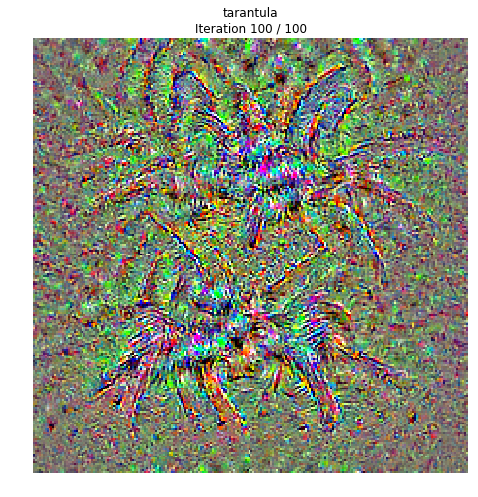

In [13]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
#target_y = 187 # Yorkshire Terrier
#target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

buckeye, horse chestnut, conker


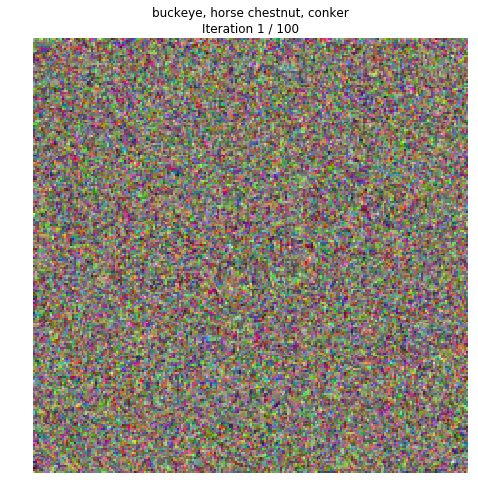

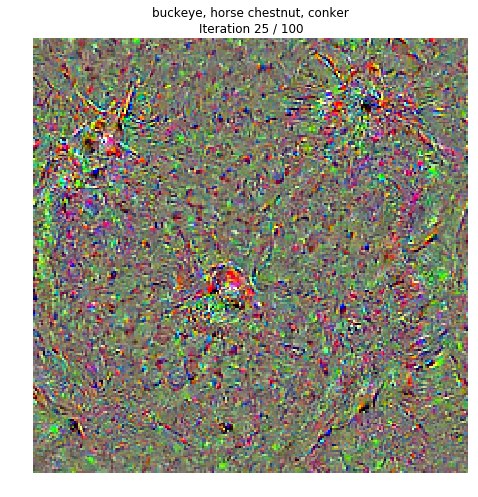

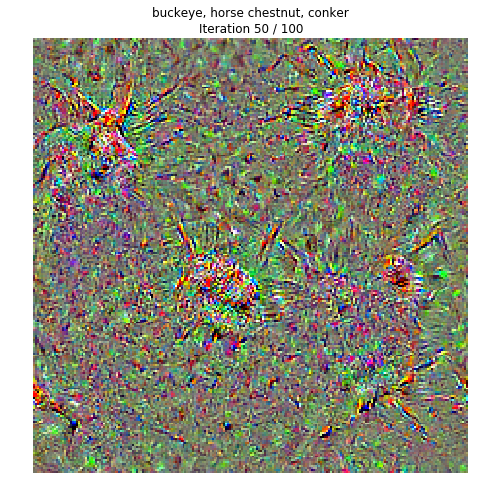

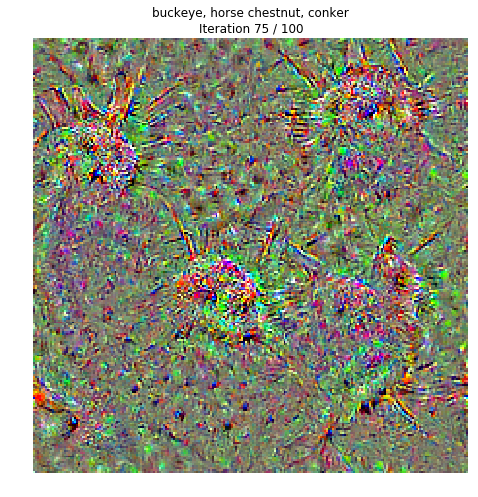

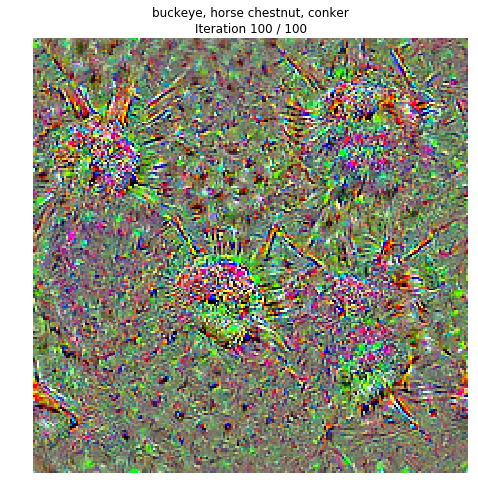

In [14]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)